# "다음 분기에 어떤 게임을 설계해야 할까?"


# 전처리

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rc('font', family='NanumBarunGothic')
  

from google.colab import files

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
myfile = files.upload()

Saving vgames2.csv to vgames2.csv


In [3]:
col = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

df = pd.read_csv('vgames2.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['Genre'] = df['Genre'].dropna()

In [4]:
#단위 통일
def to_numeric(col):
    data = col.replace(r'[M]+$', '', regex=True)
    result = data.replace(r'[K]+$', '', regex=True).astype(float) / col.str.extract(r'[\d\.]+([K]+)', expand=False).fillna(1).replace(['K'], [1000]).astype(int)
    return result

In [5]:
#수치화
for i in col:
  df[i] = to_numeric(df[i])

In [6]:
#Year 통일
df['Year'] = df['Year'].fillna(9999)

def year(x):
  if (x >= 0) & (x < 20):
    return int(2000 + x)
  elif (x > 30) & (x < 1000):
    return int(1900 + x)
  else:
    return int(x)

df['Year'] = df['Year'].apply(year)

# 플랫폼별 분석

In [7]:
platform_sales = pd.concat([pd.DataFrame(df['Platform']), df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]], axis=1)
platform_sales

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,DS,0.04,0.00,0.00,0.00
1,Wii,0.17,0.00,0.00,0.01
2,PSP,0.00,0.00,0.02,0.00
3,DS,0.04,0.00,0.00,0.00
4,PS3,0.12,0.09,0.00,0.04
...,...,...,...,...,...
16593,GC,0.15,0.04,0.00,0.01
16594,PSP,0.01,0.00,0.00,0.00
16595,PS3,0.44,0.19,0.03,0.13
16596,PSV,0.05,0.05,0.25,0.03


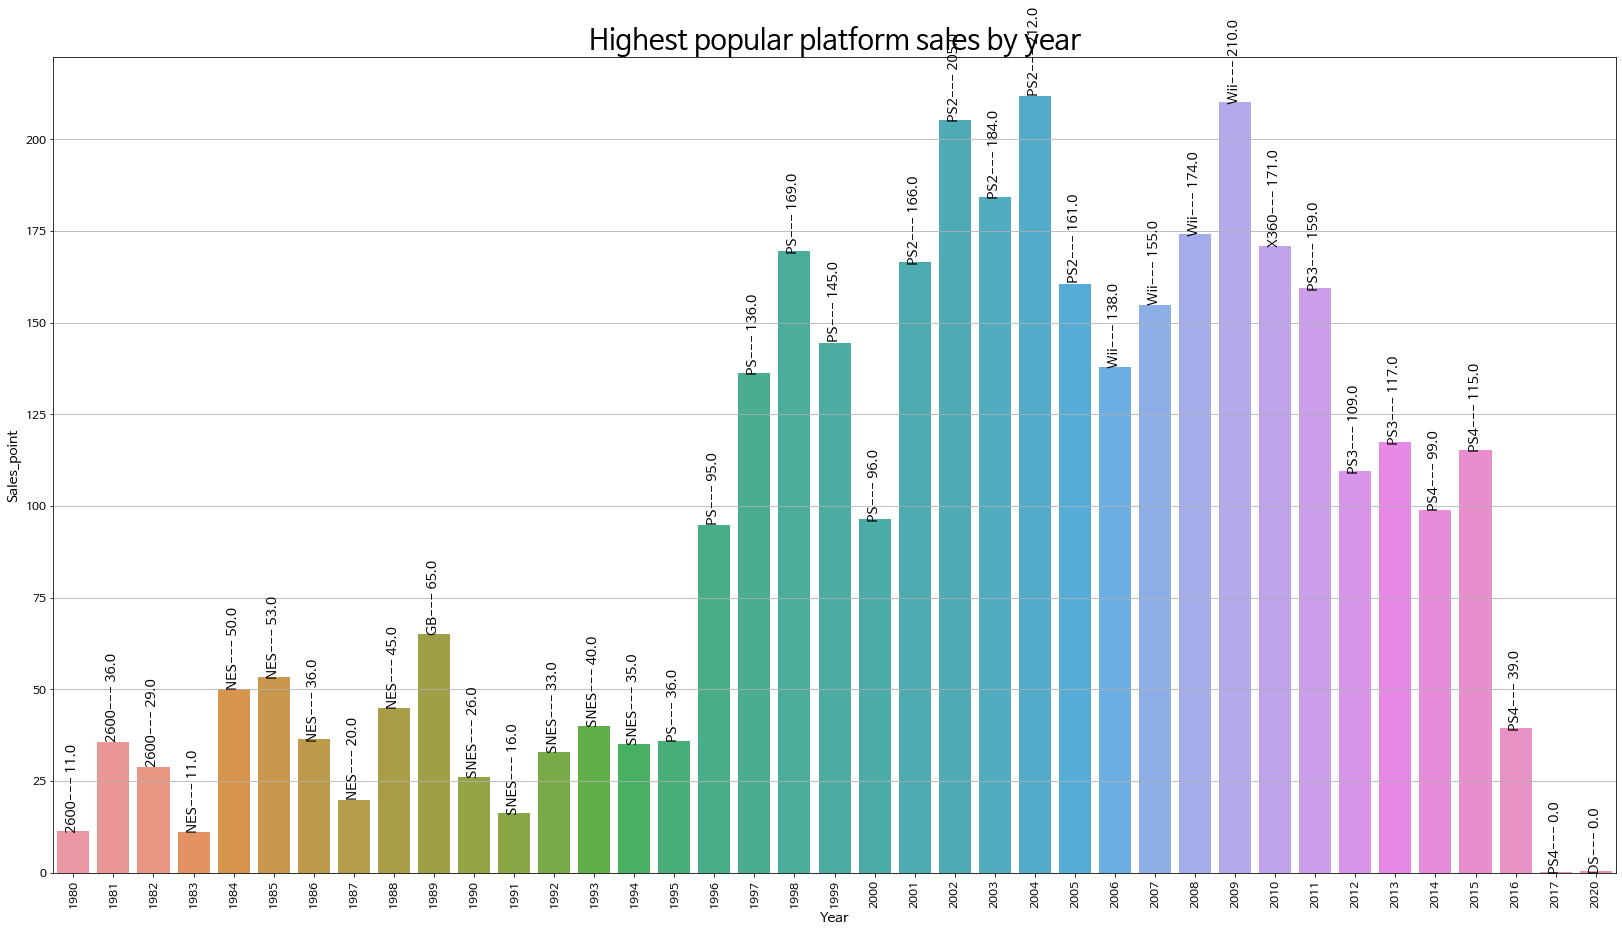

In [8]:
#년도별 가장 잘 팔린 플랫폼
def year_by_platform(xxx):
  df_year_platform = xxx.groupby(['Year','Platform']).sum()
  df_year_platform['total']=df_year_platform.sum(axis=1)

  df_year_platform.reset_index(inplace=True)
  df_year_platform.drop(['NA_Sales',
                    'EU_Sales',
                    'JP_Sales',
                    'Other_Sales'], axis=1, inplace=True)
  condition = df_year_platform[df_year_platform['Year'] == 9999].index
  df_year_platform = df_year_platform.drop(condition)
  return df_year_platform

def maxium(x):
  condition = x.groupby(['Year'])['total'].transform(max) == x['total']
  return condition

def highest_popular_genre_year(x, col1, col2, col3):
  df_year_platform_max = x[maxx].reset_index(drop=True)

  genre_name = df_year_platform_max[col1].values
  value = df_year_platform_max[col2].values
  value = np.around(value)

  plt.figure(figsize=(28,15))
  ax = sns.barplot(x=col3, y=col2, data=df_year_platform_max)

  for i in range(len(genre_name)):
    plt.text(i, value[i], ' ' +genre_name[i]+ '---' + ' ' +str(value[i]), ha = 'center', size=14, rotation=90)

  plt.xticks(rotation=90, fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel(col3, fontsize=14)
  plt.ylabel('Sales_point', fontsize=14)
  ax.set_title('Highest popular platform sales by year', fontsize=28)
  plt.grid(True, axis='y')
  return plt.show()

df_year_platform = year_by_platform(df)
maxx = maxium(df_year_platform)
highest_popular_genre_year(df_year_platform, 'Platform', 'total', 'Year')

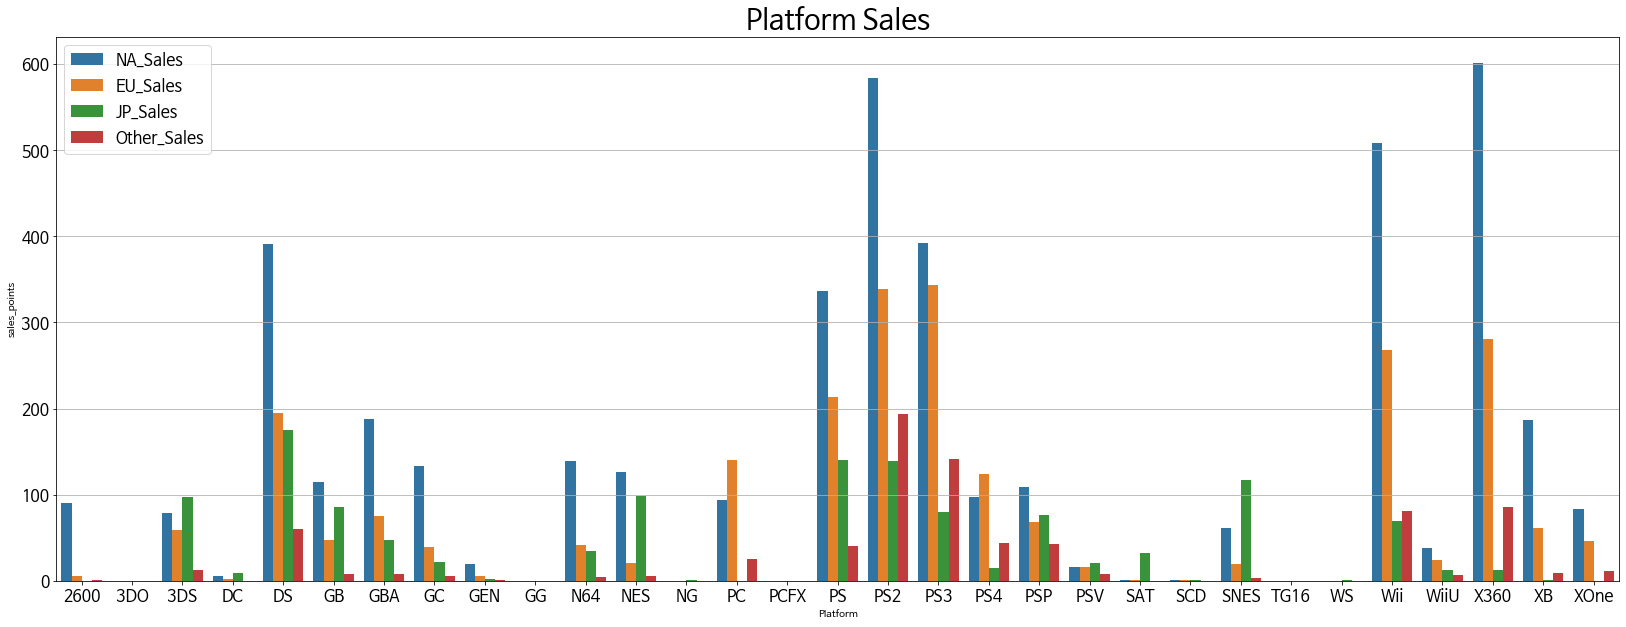

In [9]:
#platform 별 전체 판매량
def platform_melt(x, col, col1, col2):
  platform_sales_grouped = x.groupby(by=[col]).sum()
  x = platform_sales_grouped.reset_index()
  platform_sales_melt = pd.melt(x, id_vars=[col], value_vars=x.columns[1:], var_name=col1, value_name=col2)

  plt.figure(figsize=(28,10))
  ax = sns.barplot(x=col, y=col2, hue=col1, data=platform_sales_melt)
  ax.set_title('Platform Sales', fontsize=28)
  ax.legend(fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.grid(True, axis='y')
  return plt.show()

platform_melt(platform_sales, 'Platform', 'sales_nation','sales_points')

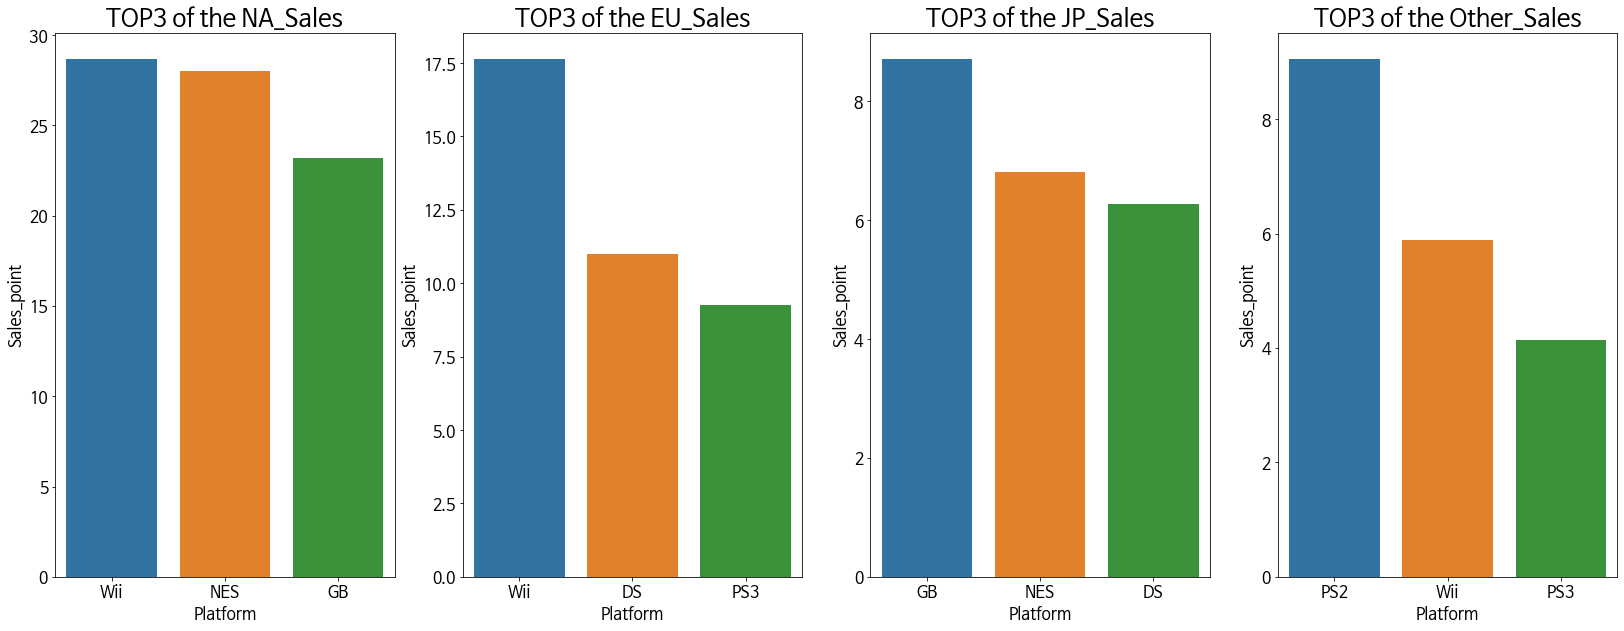

In [10]:
#platform top5
def sort_platform(x, col):
  take = x.loc[:, ['Platform',col]].sort_values(by=col, ascending=False).reset_index(drop=True).head(5)
  take.columns = ['Platform', 'Sales_point']
  return take

NA_sales_platform = sort_platform(platform_sales, 'NA_Sales')
EU_sales_platform = sort_platform(platform_sales, 'EU_Sales')
JP_sales_platform = sort_platform(platform_sales, 'JP_Sales')
Other_sales_platform = sort_platform(platform_sales, 'Other_Sales')

data_list = [NA_sales_platform, EU_sales_platform, JP_sales_platform, Other_sales_platform]
columns_list = platform_sales.columns[1:]

# 막대 그래프 그리기
fig, axs = plt.subplots(figsize=(28, 10), nrows=1, ncols=4)
for col, i, data in zip(columns_list, range(len(columns_list)), data_list):
    axs[i].set_title('TOP3 of the' + ' ' + col, fontsize=24)
    sns.barplot(x='Platform', y='Sales_point', data=data, ax=axs[i], ci=0)
    axs[i].tick_params(labelsize=16)
    axs[i].set_xlabel('Platform', fontsize=16)
    axs[i].set_ylabel('Sales_point', fontsize=16)
    
plt.show()


# 장르별 분석

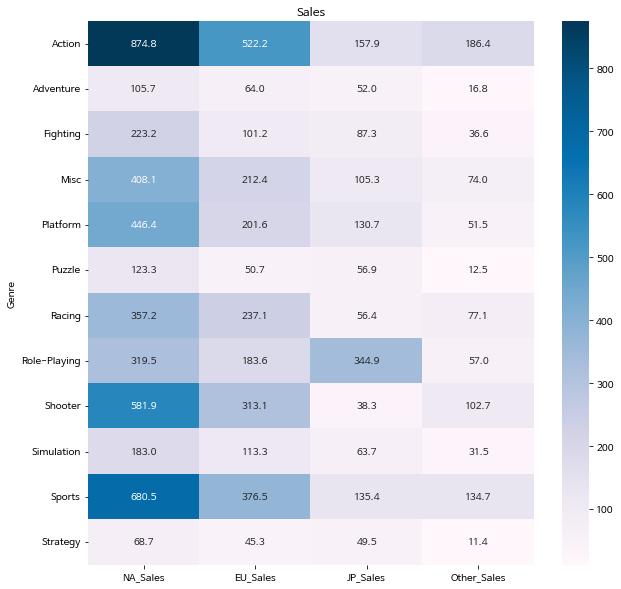

In [41]:
#장르와 마켓간의 관계를 보여주는 히트맵
comp_map = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
comp_map = comp_map.groupby(by=['Genre']).sum()

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 10))
plt.title("Sales")
sns.heatmap(comp_map, annot=True, fmt = '.1f', linecolor = 'white', cmap=colormap)
plt.show()

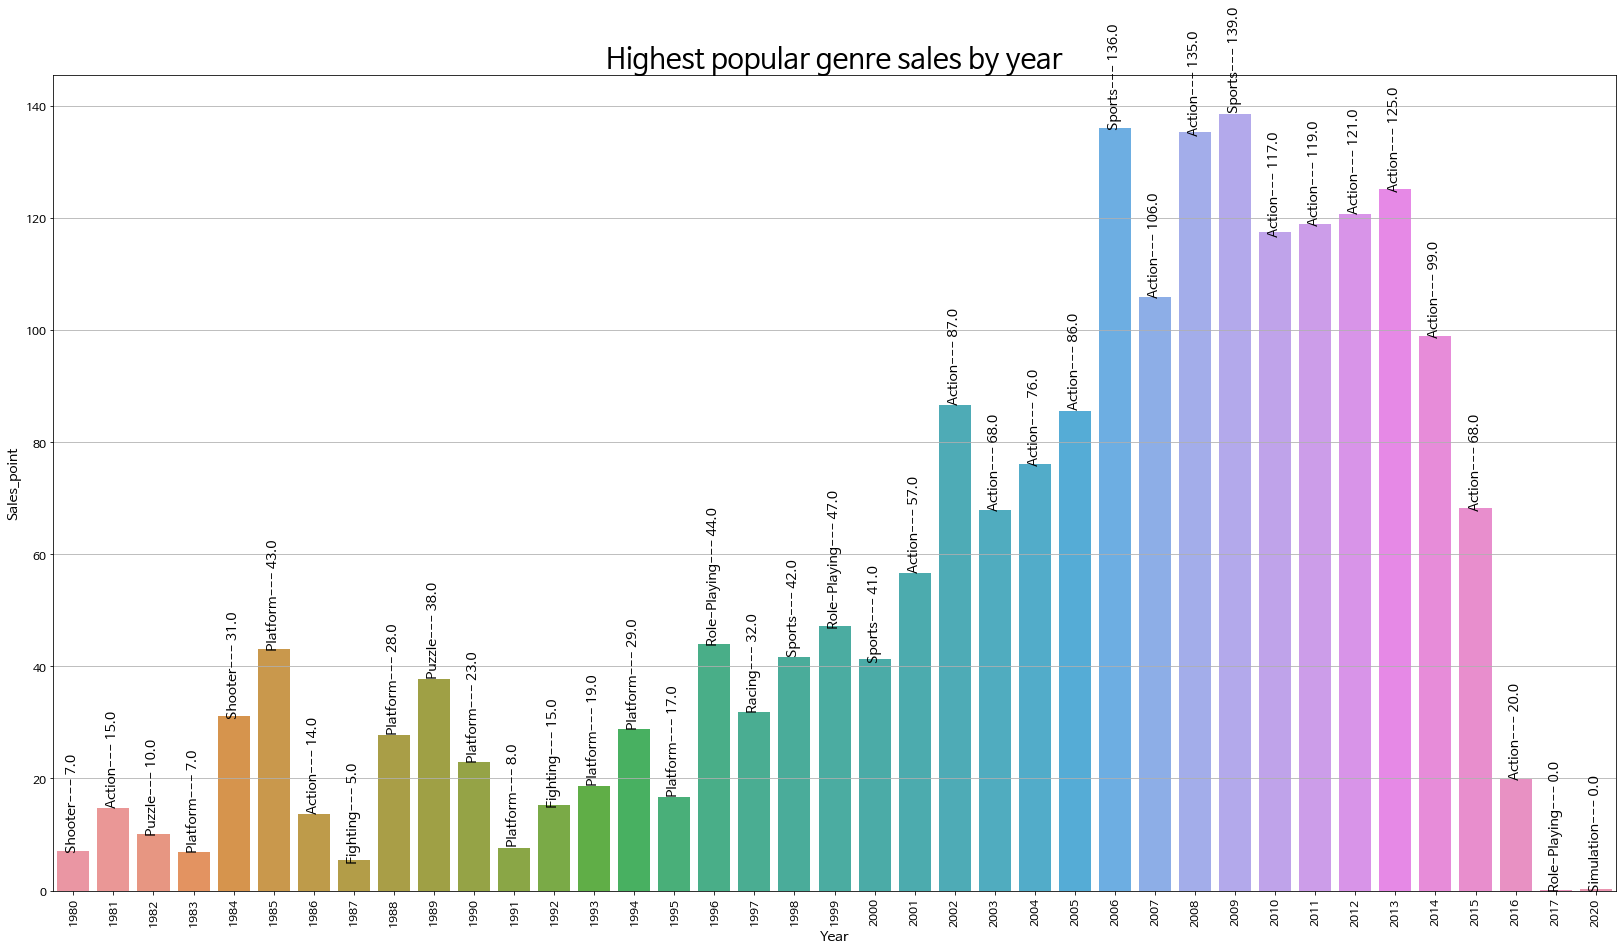

In [11]:
#년도별 가장 잘 팔린 장르
def year_by_genre(xxx):
  df_year_genre = xxx.groupby(['Year','Genre']).sum()
  df_year_genre['total']=df_year_genre.sum(axis=1)

  df_year_genre.reset_index(inplace=True)
  df_year_genre.drop(['NA_Sales',
                    'EU_Sales',
                    'JP_Sales',
                    'Other_Sales'], axis=1, inplace=True)
  condition = df_year_genre[df_year_genre['Year'] == 9999].index
  df_year_genre = df_year_genre.drop(condition)
  return df_year_genre

def maxium(x):
  condition = x.groupby(['Year'])['total'].transform(max) == x['total']
  return condition

def highest_popular_genre_year(x, col1, col2, col3):
  df_year_genre_max = x[maxx].reset_index(drop=True)

  genre_name = df_year_genre_max[col1].values
  value = df_year_genre_max[col2].values
  value = np.around(value)

  plt.figure(figsize=(28,15))
  ax = sns.barplot(x=col3, y=col2, data=df_year_genre_max)

  for i in range(len(genre_name)):
    plt.text(i, value[i], ' ' +genre_name[i]+ '---' + ' ' +str(value[i]), ha = 'center', size=14, rotation=90)

  plt.xticks(rotation=90, fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel(col3, fontsize=14)
  plt.ylabel('Sales_point', fontsize=14)
  ax.set_title('Highest popular genre sales by year', fontsize=28)
  plt.grid(True, axis='y')
  return plt.show()

df_year_genre = year_by_genre(df)
maxx = maxium(df_year_genre)
highest_popular_genre_year(df_year_genre, 'Genre', 'total', 'Year')

In [12]:
game_genre = pd.concat([df['Genre'], df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]], axis=1)
game_genre

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Action,0.04,0.00,0.00,0.00
1,Action,0.17,0.00,0.00,0.01
2,Adventure,0.00,0.00,0.02,0.00
3,Misc,0.04,0.00,0.00,0.00
4,Platform,0.12,0.09,0.00,0.04
...,...,...,...,...,...
16593,Platform,0.15,0.04,0.00,0.01
16594,Action,0.01,0.00,0.00,0.00
16595,Sports,0.44,0.19,0.03,0.13
16596,Action,0.05,0.05,0.25,0.03


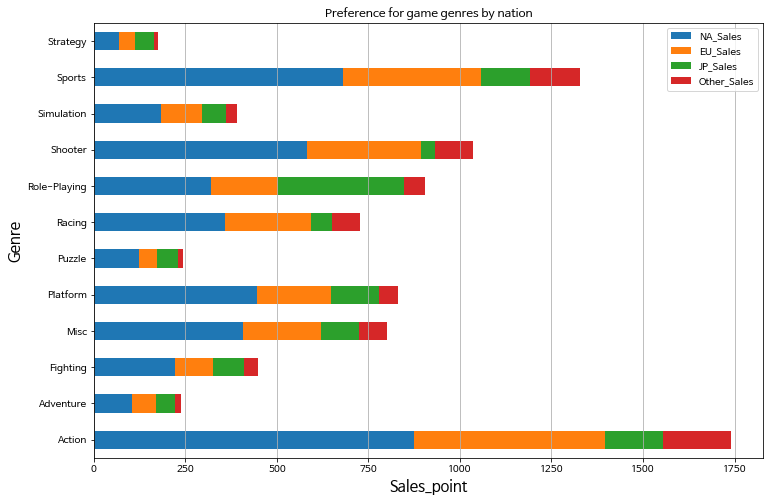

In [13]:
#Stacked
grouped_genre_sales = game_genre.groupby('Genre').sum()
grouped_genre_sales.plot.barh(figsize = (12, 8), stacked=True)

plt.xlabel('Sales_point', fontsize=15)
plt.ylabel('Genre', fontsize=15)
plt.grid(True, axis='x')
plt.title("Preference for game genres by nation")
plt.show()

In [14]:
grouped_genre_sales.reset_index(inplace=True)

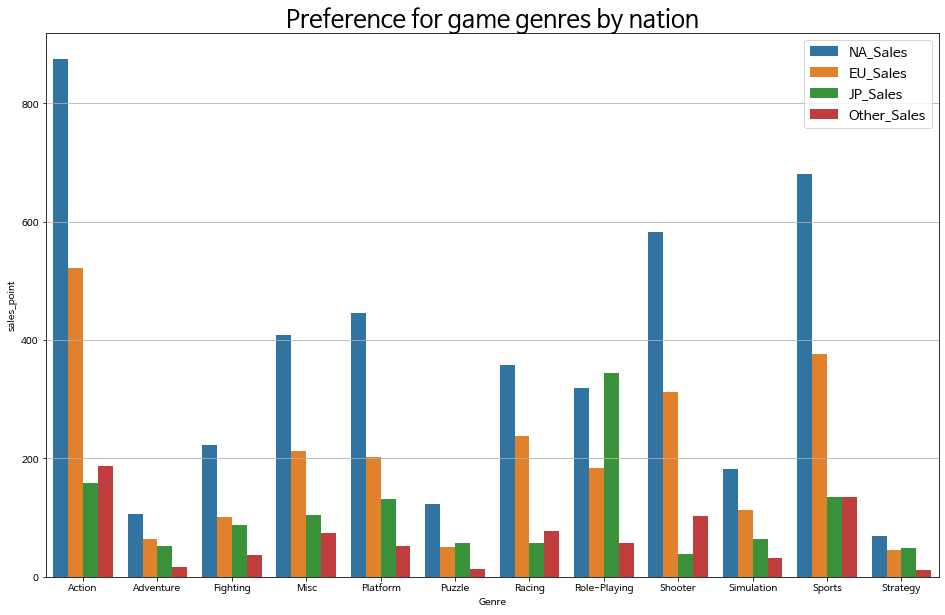

In [15]:
genre_melted = pd.melt(grouped_genre_sales, id_vars=['Genre'], value_vars=grouped_genre_sales.columns[1:], var_name='sales_nation', value_name='sales_point')
plt.figure(figsize=(16, 10))
sns.barplot(data=genre_melted, x='Genre', y='sales_point', hue='sales_nation')
plt.title('Preference for game genres by nation', loc='center', fontsize=24)
plt.legend(fontsize=14)
plt.grid(True, axis='y')
plt.show()

In [16]:
condition = df[df['Year'] == 9999].index
df1 = df.drop(condition)

In [17]:
df_year_genre = df1.groupby(['Year','Genre']).sum()
df_year_genre['total']=df_year_genre.sum(axis=1)
df_year_genre.reset_index(inplace=True)
df_year_genre.drop(['NA_Sales',
                    'EU_Sales',
                    'JP_Sales',
                    'Other_Sales'], axis=1, inplace=True)
def maxium(x):
  condition = x.groupby(['Year'])['total'].transform(max) == x['total']
  return condition

maxx = maxium(df_year_genre)

df_year_genre_max = df_year_genre[maxx].reset_index(drop=True)
df_year_genre_max

,Year,Genre,total
0,1980,Shooter,7.07
1,1981,Action,14.79
2,1982,Puzzle,10.04
3,1983,Platform,6.93
4,1984,Shooter,31.10
5,1985,Platform,43.17
6,1986,Action,13.74
7,1987,Fighting,5.42
8,1988,Platform,27.73
9,1989,Puzzle,37.75


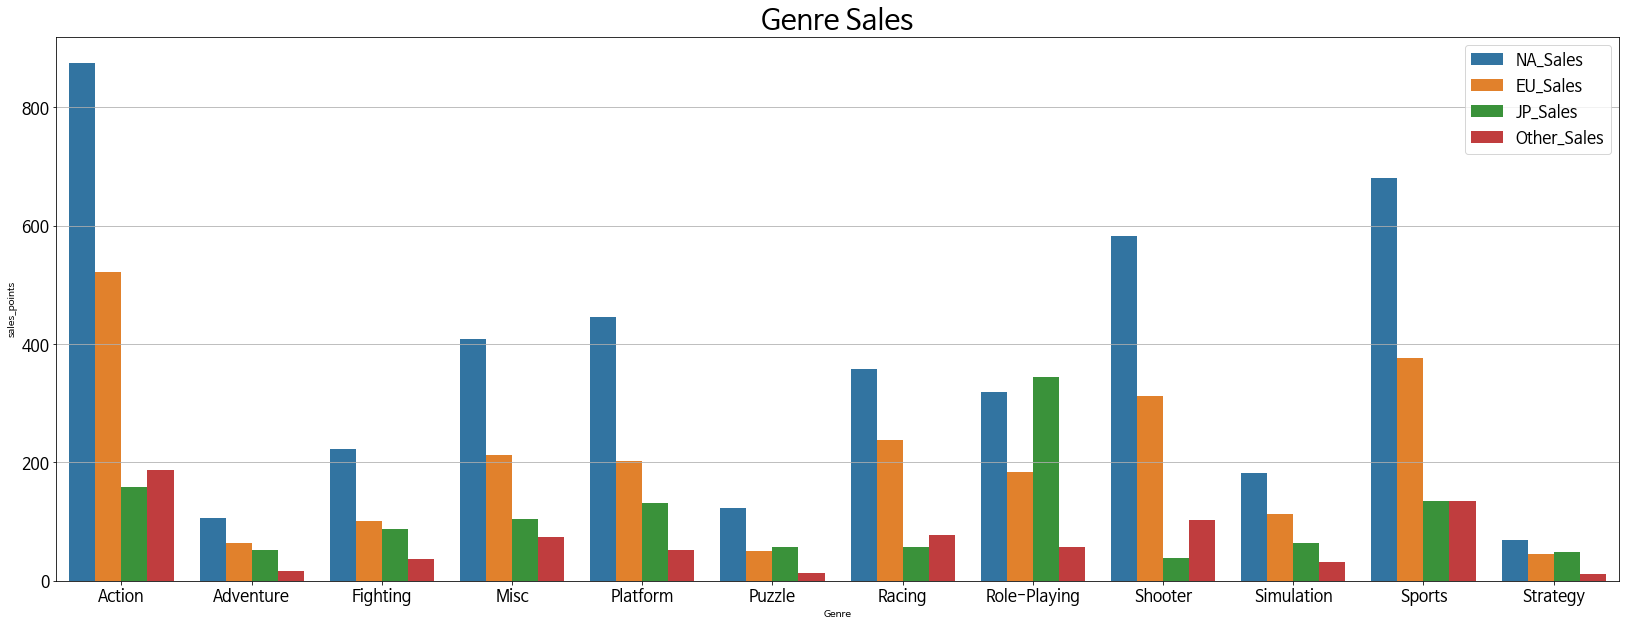

In [18]:
#장르 선호도 국가별 TOP3
game_genre_grouped = game_genre.groupby(by=['Genre']).sum()
game_genre_grouped = game_genre_grouped.reset_index()

game_genre_melt = pd.melt(game_genre_grouped, id_vars=['Genre'], value_vars=game_genre_grouped.columns[1:],
                         var_name='sales_nation', value_name='sales_points')

plt.figure(figsize=(28,10))
ax = sns.barplot(x='Genre', y='sales_points', hue='sales_nation', data=game_genre_melt)
ax.set_title('Genre Sales', fontsize=28)
ax.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, axis='y')
plt.show()

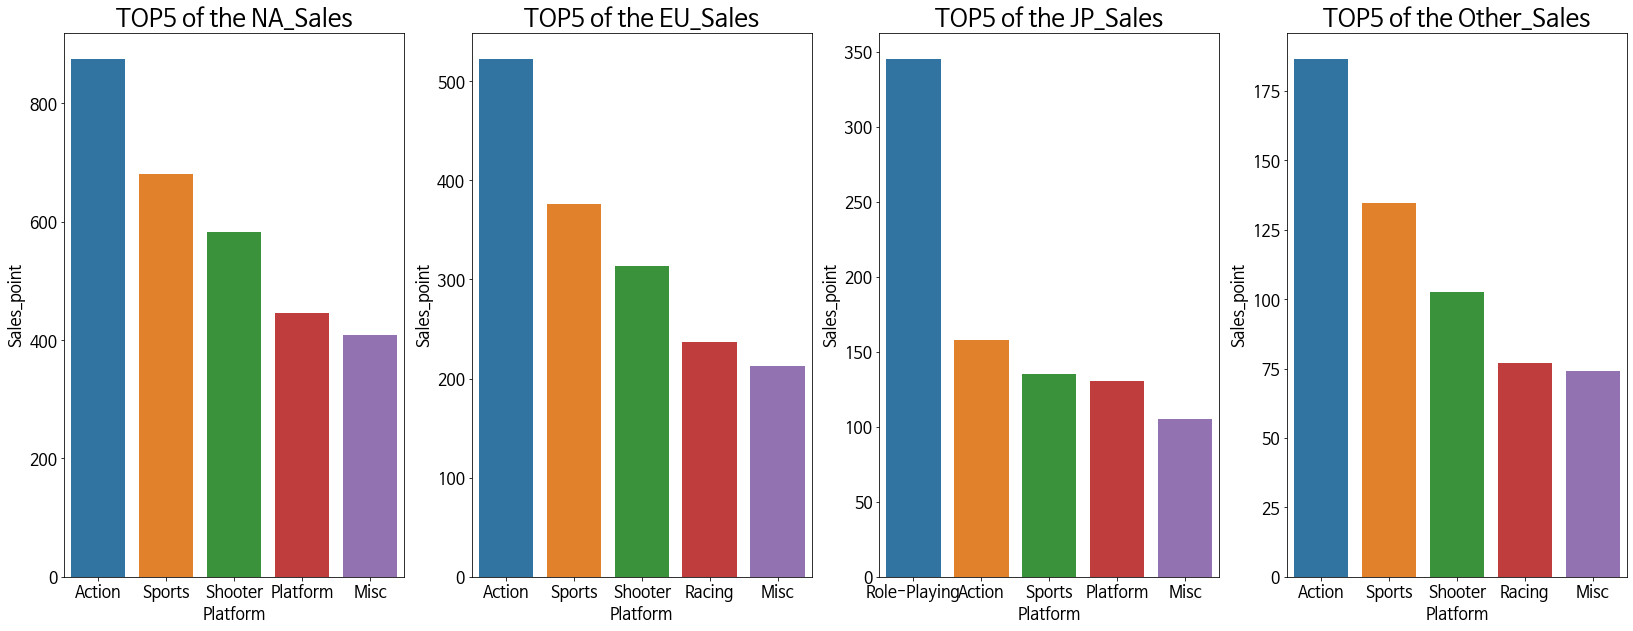

In [19]:
#Genre top5
def sort_platform(x, col):
  take = x.loc[:, ['Genre',col]].sort_values(by=col, ascending=False).reset_index(drop=True).head(5)
  take.columns = ['Genre', 'Sales_point']
  return take

NA_sales_platform = sort_platform(game_genre_grouped, 'NA_Sales')
EU_sales_platform = sort_platform(game_genre_grouped, 'EU_Sales')
JP_sales_platform = sort_platform(game_genre_grouped, 'JP_Sales')
Other_sales_platform = sort_platform(game_genre_grouped, 'Other_Sales')

data_list = [NA_sales_platform, EU_sales_platform, JP_sales_platform, Other_sales_platform]
columns_list = game_genre_grouped.columns[1:]
# 막대 그래프 그리기
fig, axs = plt.subplots(figsize=(28, 10), nrows=1, ncols=4)
for col, i, data in zip(columns_list, range(len(columns_list)), data_list):
    axs[i].set_title('TOP5 of the' + ' ' + col, fontsize=24)
    sns.barplot(x='Genre', y='Sales_point', data=data, ax=axs[i])
    axs[i].tick_params(labelsize=16)
    axs[i].set_xlabel('Platform', fontsize=16)
    axs[i].set_ylabel('Sales_point', fontsize=16)
    
plt.show()


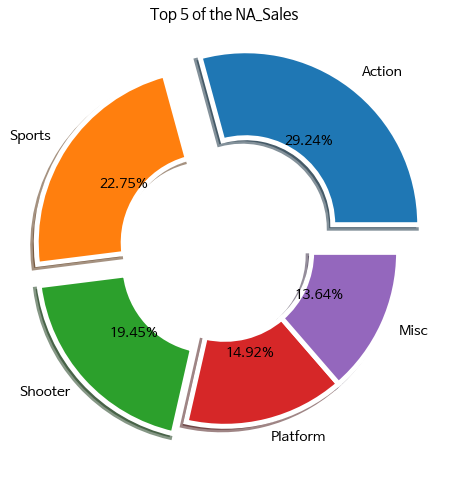

In [20]:
#top5 Genre pieplot NA
def pieplot1(x, col):
  data = x['Sales_point'].values.tolist()
  genre_1 = x['Genre'].values.tolist()
  title = 'Top 5 of the ' + col
  group_explodes = (0.2, 0.1, 0.1, 0, 0)
  wedgeprops={'width': 0.5, 'edgecolor': 'w', 'linewidth': 5}


  plt.rcParams['figure.figsize'] = [12, 8]
  plt.pie(data,
        explode = group_explodes,
        shadow=True,
        startangle=0,
        autopct='%1.2f%%',
        textprops={'fontsize': 14},
        labels = genre_1,
        wedgeprops = wedgeprops)
  plt.title(title, fontsize=15, pad=16)
        
  return plt.show()


pieplot1(NA_sales_platform, 'NA_Sales')

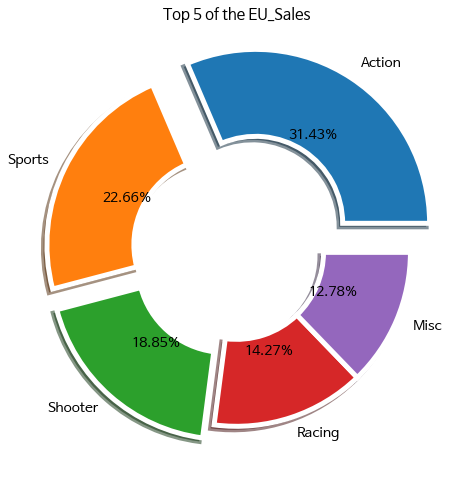

In [21]:
#top5 Genre pieplot EU

pieplot1(EU_sales_platform, 'EU_Sales')

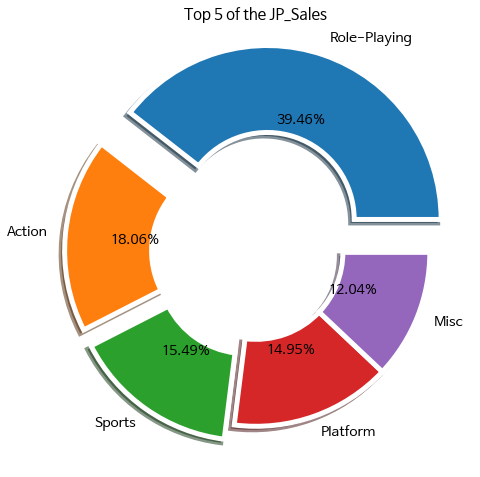

In [22]:
#top5 Genre pieplot JP

pieplot1(JP_sales_platform, 'JP_Sales')

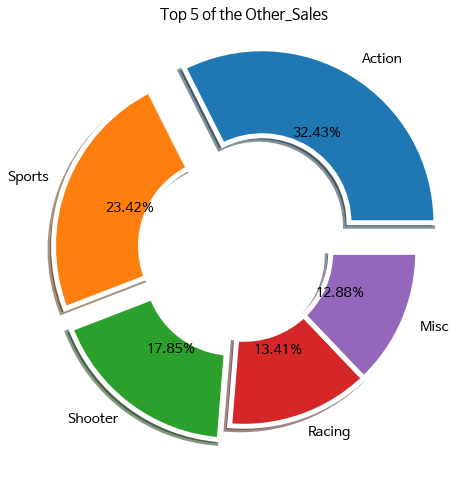

In [23]:
#top5 Genre pieplot Others

pieplot1(Other_sales_platform, 'Other_Sales')

# 퍼블리셔 별

In [24]:
publisher_sales = pd.concat([pd.DataFrame(df['Publisher']), df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]], axis=1)
publisher_sales

,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Destineer,0.04,0.00,0.00,0.00
1,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Alchemist,0.00,0.00,0.02,0.00
3,Zoo Games,0.04,0.00,0.00,0.00
4,D3Publisher,0.12,0.09,0.00,0.04
...,...,...,...,...,...
16593,Vivendi Games,0.15,0.04,0.00,0.01
16594,Rising Star Games,0.01,0.00,0.00,0.00
16595,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Tecmo Koei,0.05,0.05,0.25,0.03


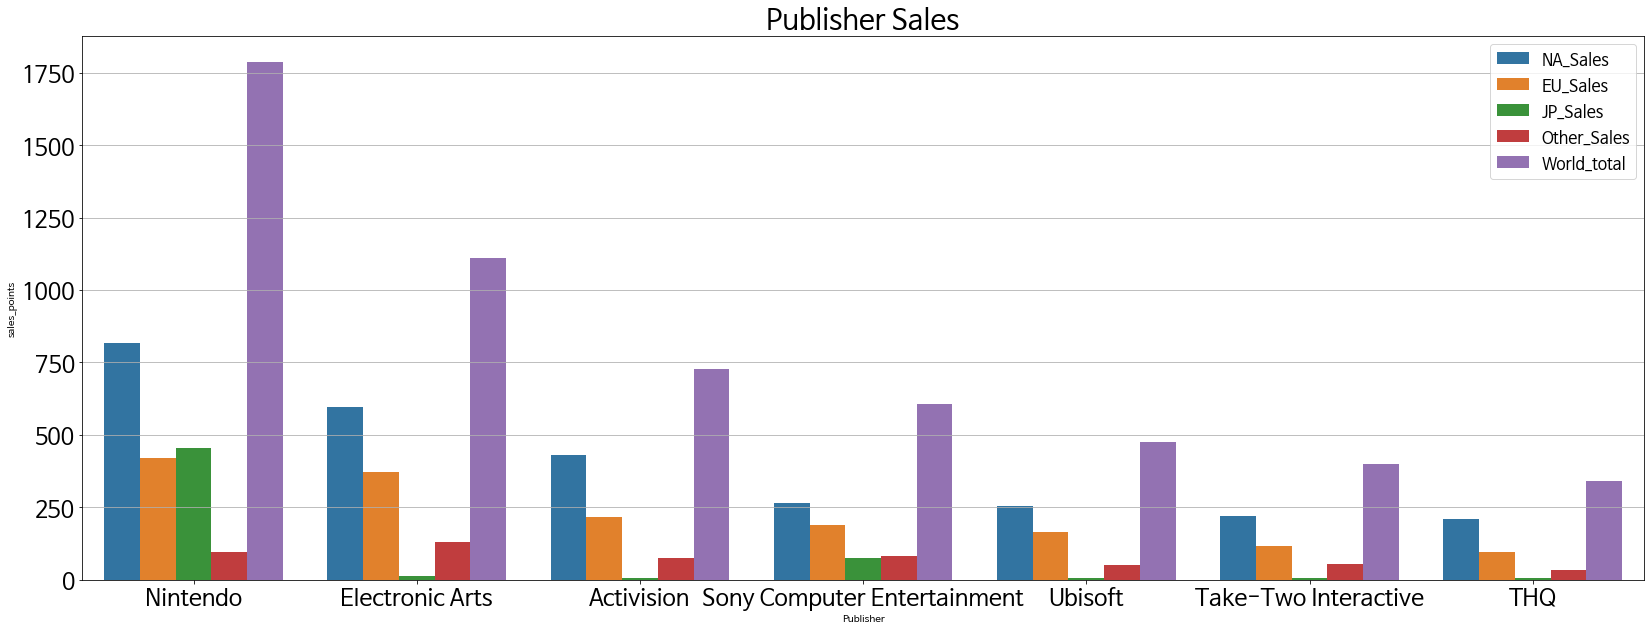

In [25]:
#publisher 별 판매량 상위 7개 그룹
publisher_sales_grouped = publisher_sales.groupby(by=['Publisher']).sum()
publisher_sales_grouped['World_total'] = publisher_sales_grouped.sum(axis=1)
publisher_sales_grouped = publisher_sales_grouped.reset_index().sort_values(by = 'World_total', ascending=False).head(7)
publisher_sales_melt = pd.melt(publisher_sales_grouped, id_vars=['Publisher'], value_vars=publisher_sales_grouped.columns[1:],
                         var_name='sales_nation', value_name='sales_points')

plt.figure(figsize=(28,10))
ax = sns.barplot(x='Publisher', y='sales_points', hue='sales_nation', data=publisher_sales_melt)
ax.set_title('Publisher Sales', fontsize=28)
ax.legend(fontsize=16)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.grid(True, axis='y')
plt.show()

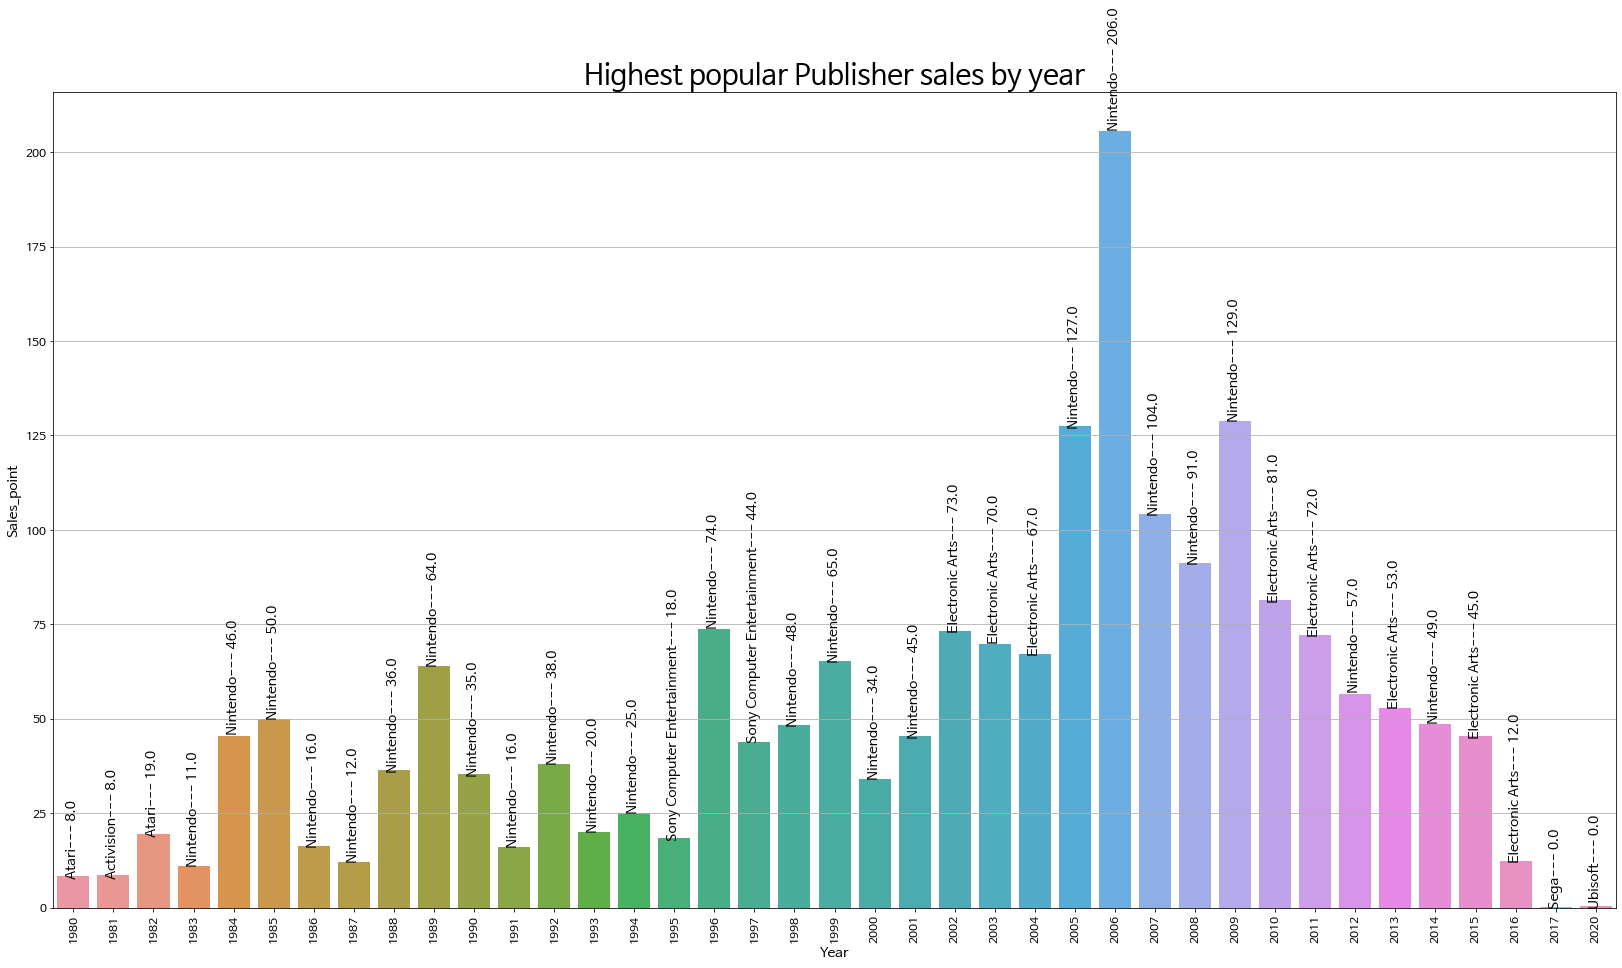

In [26]:
#연도별로 가장 잘 팔린 퍼블리셔
def year_by_pub(xxx):
  df_year_pub = xxx.groupby(['Year','Publisher']).sum()
  df_year_pub['total']=df_year_pub.sum(axis=1)
  df_year_pub.reset_index(inplace=True)
  df_year_pub.drop(['NA_Sales',
                    'EU_Sales',
                    'JP_Sales',
                    'Other_Sales'], axis=1, inplace=True)
  condition = df_year_pub[df_year_pub['Year'] == 9999].index
  df_year_pub = df_year_pub.drop(condition)
  return df_year_pub

def maxium(x):
  condition = x.groupby(['Year'])['total'].transform(max) == x['total']
  return condition

def highest_popular_pub_year(x, col1, col2, col3, col4):
  df_year_pub_max = df_year_pub[maxx].reset_index(drop=True)

  genre_name = df_year_pub_max[col1].values
  value = df_year_pub_max[col2].values
  value = np.around(value)

  plt.figure(figsize=(28,15))
  ax = sns.barplot(x=col3, y=col2, data=df_year_pub_max)

  for i in range(len(genre_name)):
    plt.text(i, value[i], ' ' +genre_name[i]+ '---' + ' ' +str(value[i]), ha = 'center', size=14, rotation=90)

  plt.xticks(rotation=90, fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel(col3, fontsize=14)
  plt.ylabel(col4, fontsize=14)
  ax.set_title('Highest popular Publisher sales by year', fontsize=28)
  plt.grid(True, axis='y')
  return plt.show()

df_year_pub = year_by_pub(df)
maxx = maxium(df_year_pub)
highest_popular_pub_year(df_year_pub, 'Publisher', 'total', 'Year', 'Sales_point')


# 연도별로 나누기

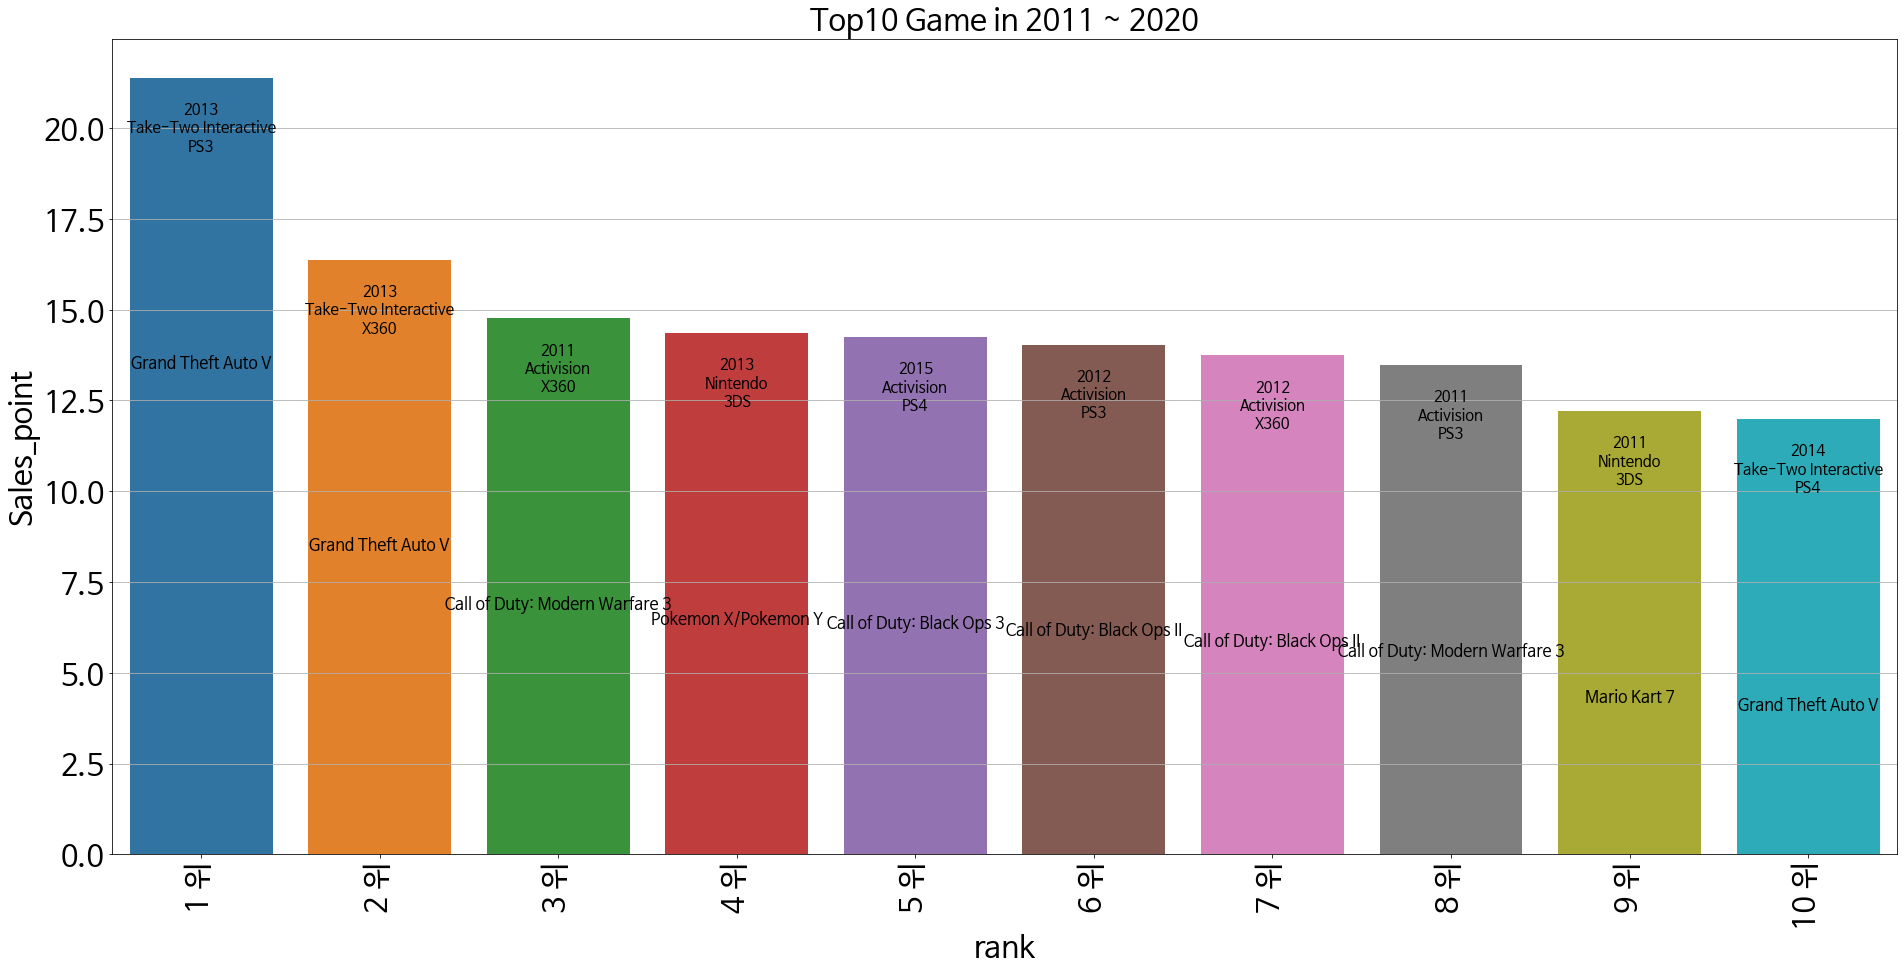

In [27]:
#최근 10년간 가장 많이 팔린 게임 Top10
def filter1(x):
  condition1 = (x.Year >= 2011) & (x.Year <= 2020)
  df_new = x[condition1]
  df_new['total'] = df_new.loc[:, 'NA_Sales':'Other_Sales'].sum(axis=1)
  df_new = df_new.sort_values(by='total', ascending=False).head(10).reset_index(drop=True)
  return df_new

def graph1(x):
  rank = [str(i)+' 위' for i in range(1, 11)]

  x['rank'] = rank

  plt.figure(figsize=(32,15))
  a = sns.barplot(x='rank', y='total', data=x)

  i = 0
  for name, year, val, platform, publisher in zip(x.Name, x.Year, x.total, x.Platform, x.Publisher):
    a.text(x=i, y=val-8, s=(name), color='black', ha='center', fontsize=16)
    a.text(x=i, y=val-2, s=(str(year) + '\n' + publisher + '\n' + platform), color='black', ha='center', fontsize=15)
    i+=1

  plt.xticks(rotation=90, fontsize=30)
  plt.yticks(fontsize=30)
  plt.xlabel('rank', fontsize=30)
  plt.ylabel('Sales_point', fontsize=30)
  plt.title('Top10 Game in 2011 ~ 2020', fontsize=30)
  plt.grid(True, axis='y')
  return plt.show()

df_new = filter1(df)
graph1(df_new)

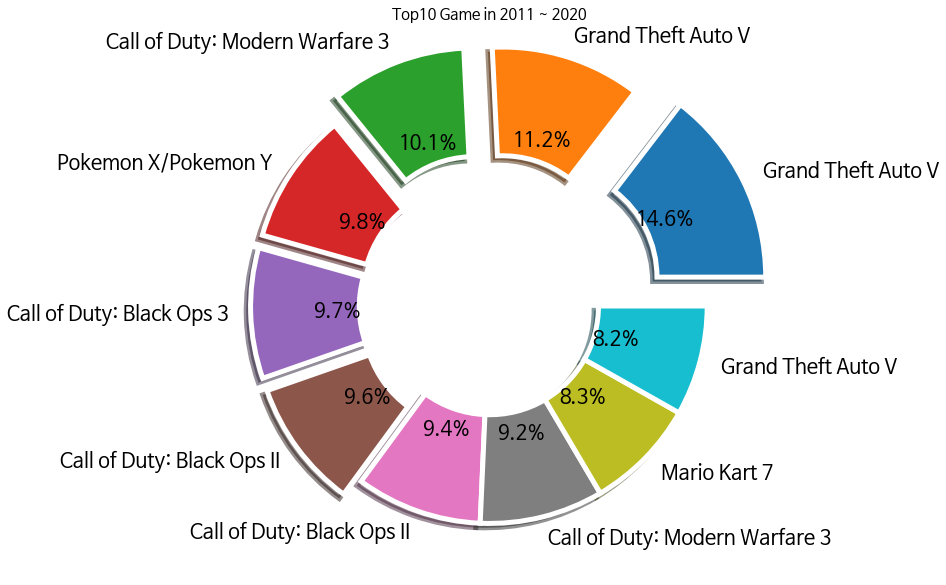

In [28]:
#최근 10년간 가장 많이 팔린 게임 pieplot Top10
def pieplot(x):
  data = x['total'].values.tolist()
  game_names = x['Name'].values.tolist()
  title = 'Top10 Game in 2011 ~ 2020'
  group_explodes = (0.3, 0.2, 0.2, 0.1, 0.1, 0.1, 0, 0, 0, 0)
  wedgeprops={'width': 0.5, 'edgecolor': 'w', 'linewidth': 5}

  plt.rcParams['figure.figsize'] = [15, 10]
  plt.pie(data,
        explode = group_explodes,
        shadow=True,
        startangle=0,
        autopct='%1.1f%%',
        textprops={'fontsize': 20},
        labels = game_names,
        wedgeprops=wedgeprops)
  plt.title(title, fontsize=15, pad=16)
        
  return plt.show()

pieplot(df_new)

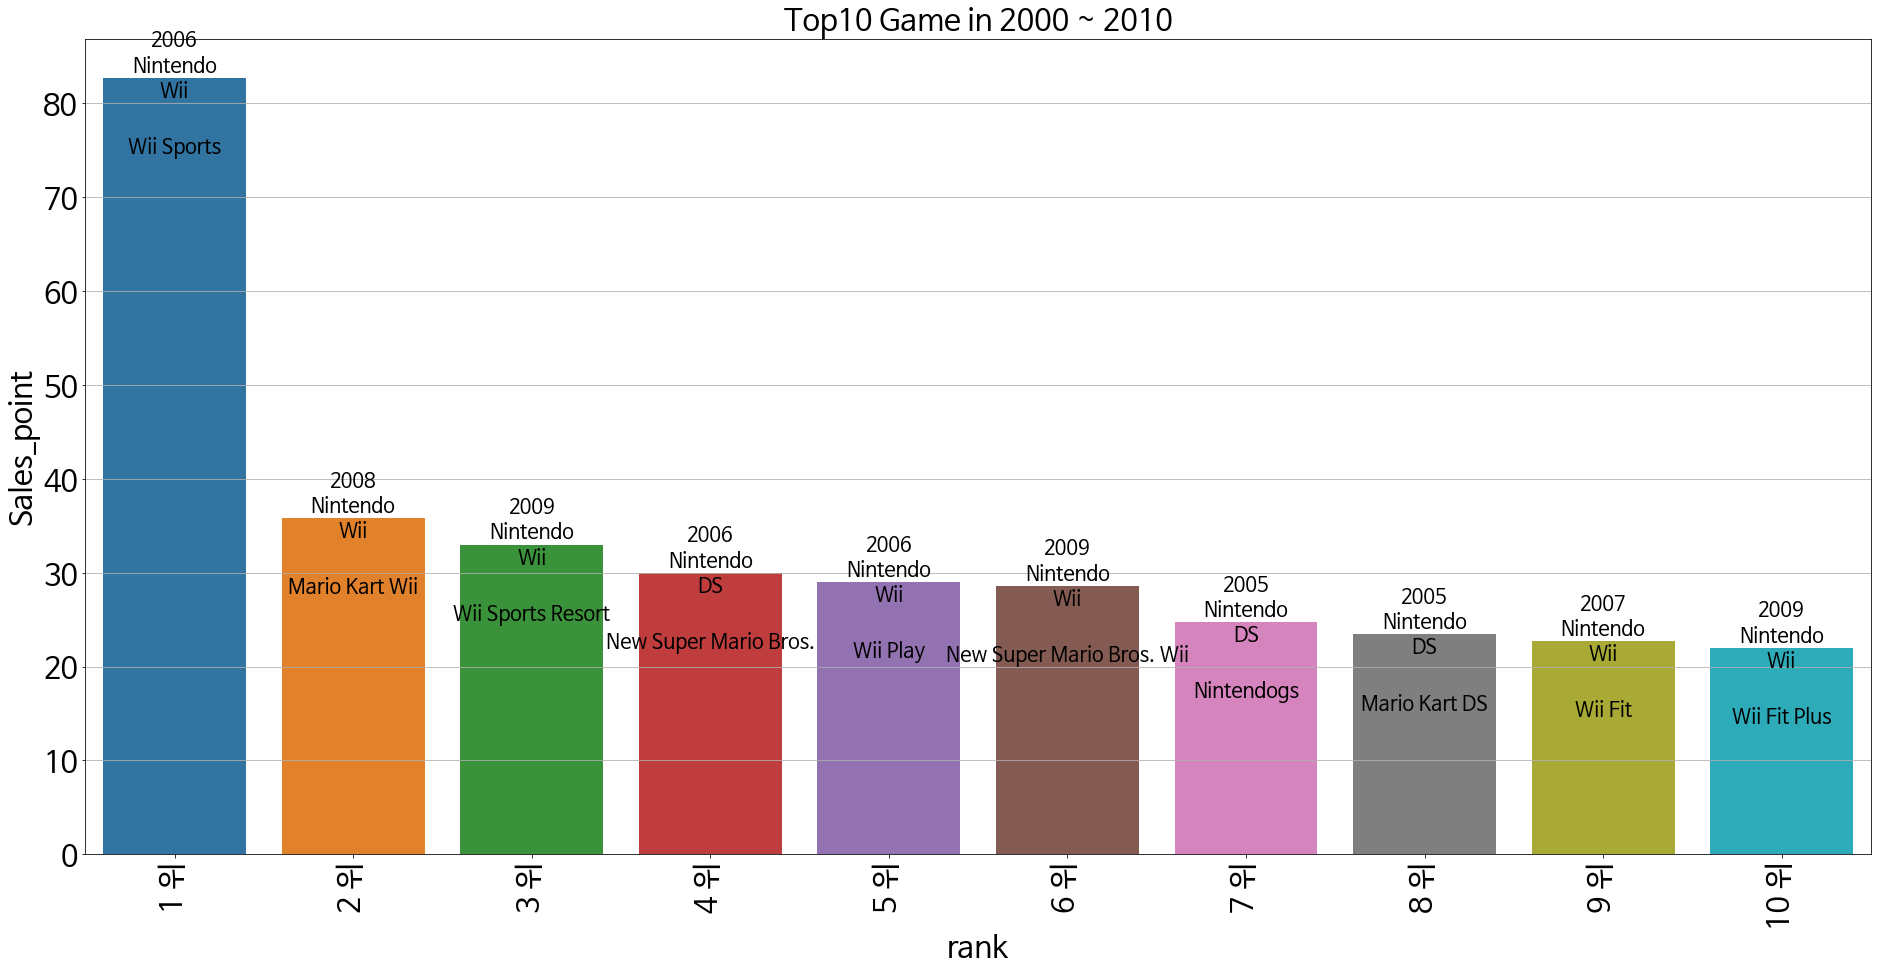

In [29]:
#2000 ~ 2010 10년간 가장 많이 팔린 게임 Top10
def filter2(x):
  condition2 = (x.Year >= 2000) & (x.Year <= 2010)
  df_new1 = x[condition2]
  df_new1['total'] = df_new1.loc[:, 'NA_Sales':'Other_Sales'].sum(axis=1)
  df_new1 = df_new1.sort_values(by='total', ascending=False).head(10).reset_index(drop=True)
  return df_new1

def graph2(df):

  rank = [str(i)+' 위' for i in range(1, 11)]

  df['rank'] = rank

  plt.figure(figsize=(32,15))
  a = sns.barplot(x='rank', y='total', data=df)

  i = 0
  for name, year, val, platform, publisher in zip(df.Name, df.Year, df.total, df.Platform, df.Publisher):
    a.text(x=i, y=val-8, s=(name), color='black', ha='center', fontsize=20)
    a.text(x=i, y=val-2, s=(str(year) + '\n' + publisher + '\n' + platform), color='black', ha='center', fontsize=20)
    i+=1

  plt.xticks(rotation=90, fontsize=30)
  plt.yticks(fontsize=30)
  plt.xlabel('rank', fontsize=30)
  plt.ylabel('Sales_point', fontsize=30)
  plt.title('Top10 Game in 2000 ~ 2010', fontsize=30)
  plt.grid(True, axis='y')
  plt.show()
  return plt.show()

df_new1 = filter2(df)
graph2(df_new1)

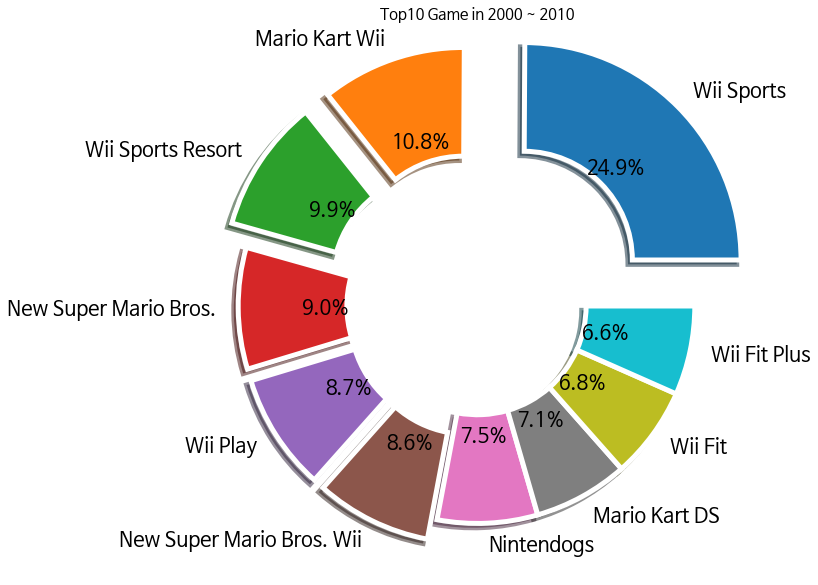

In [30]:
#2000 ~ 2010 10년간 가장 많이 팔린 게임 Top10
def pieplot(x):
  data = x['total'].values.tolist()
  game_names = x['Name'].values.tolist()
  title = 'Top10 Game in 2000 ~ 2010'
  group_explodes = (0.3, 0.2, 0.2, 0.1, 0.1, 0.1, 0, 0, 0, 0)
  wedgeprops={'width': 0.5, 'edgecolor': 'w', 'linewidth': 5}

  plt.rcParams['figure.figsize'] = [15, 10]
  plt.pie(data,
        explode = group_explodes,
        shadow=True,
        startangle=0,
        autopct='%1.1f%%',
        textprops={'fontsize': 20},
        labels = game_names,
        wedgeprops=wedgeprops)
  plt.title(title, fontsize=15, pad=16)
        
  return plt.show()

pieplot(df_new1)

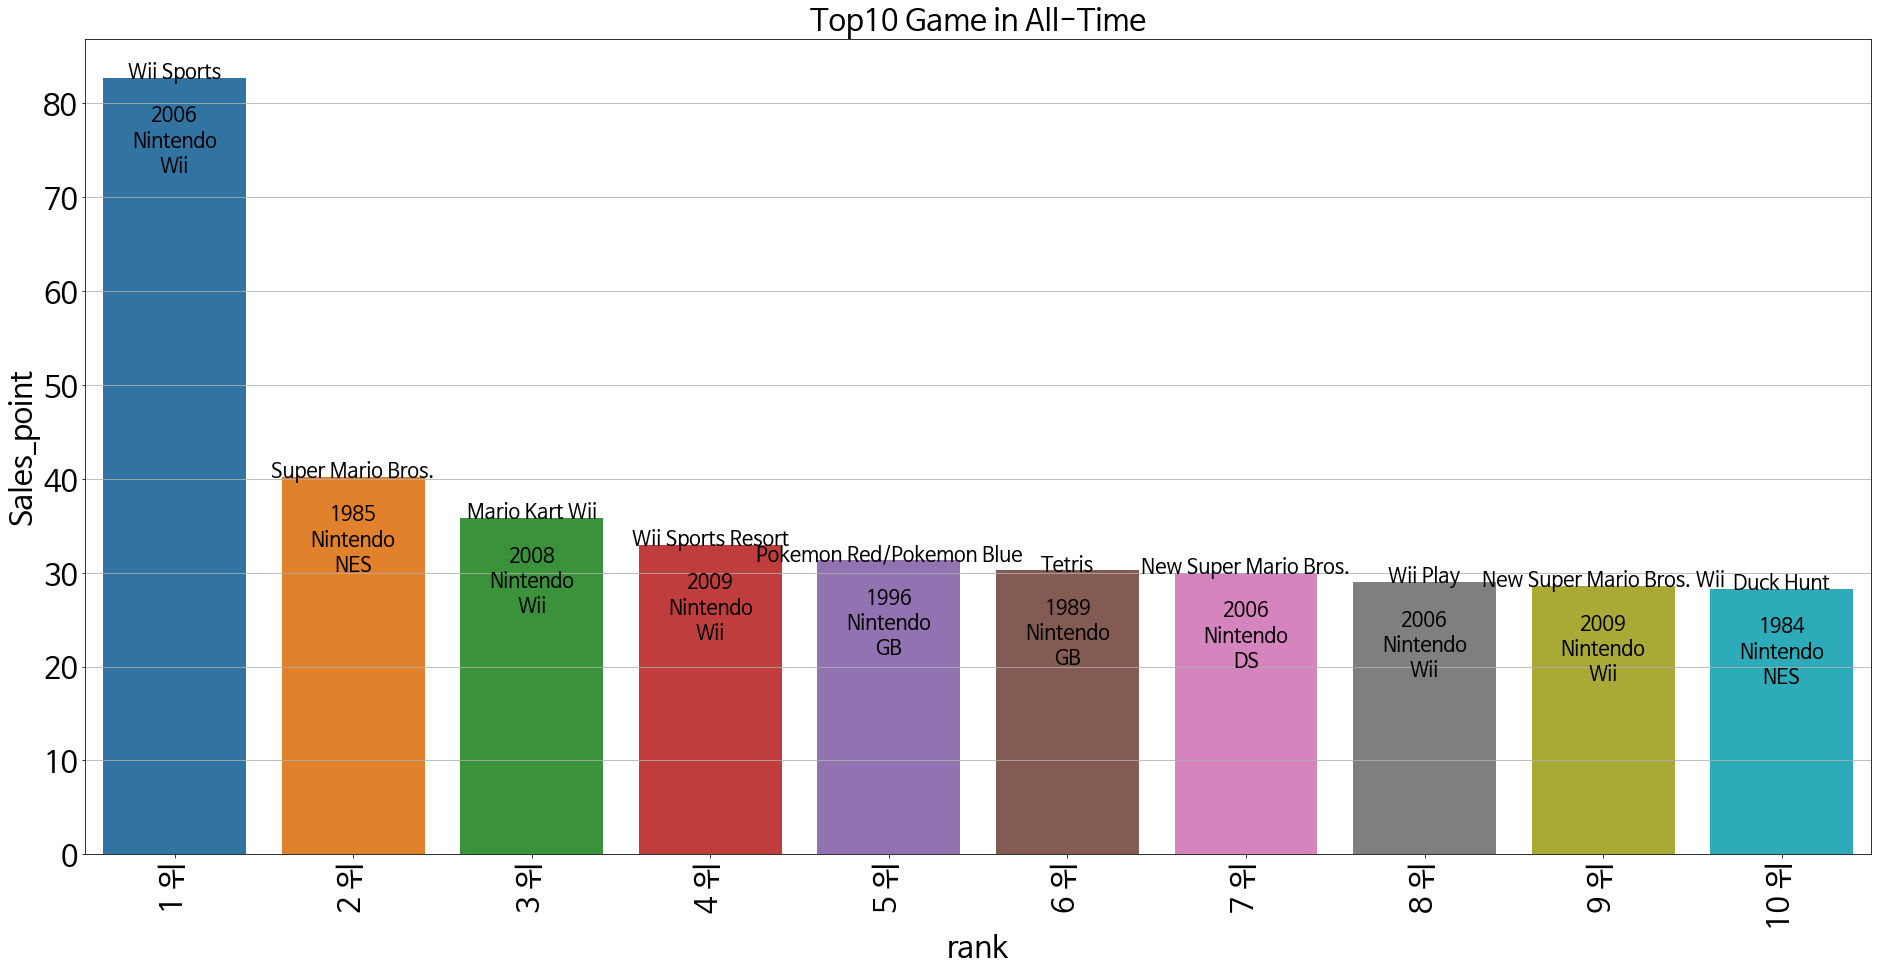

In [31]:
#All-Time 중에서 가장 많이 팔린 게임 Top10
def filter3(x):
  condition1 = (x.Year >= 1980) & (x.Year <= 2020)
  df_total = x[condition1]
  df_total['total'] = df_total.loc[:, 'NA_Sales':'Other_Sales'].sum(axis=1)
  df_total = df_total.sort_values(by='total', ascending=False).head(10).reset_index(drop=True)
  return df_total

def graph3(df):
  rank = [str(i)+' 위' for i in range(1, 11)]

  df['rank'] = rank

  plt.figure(figsize=(32,15))
  a = sns.barplot(x='rank', y='total', data=df)
  i = 0
  for name, year, val, platform, publisher in zip(df.Name, df.Year, df.total, df.Platform, df.Publisher):
    a.text(x=i, y=val, s=(name), color='black', ha='center', fontsize=20)
    a.text(x=i, y=val-10, s=(str(year) + '\n' + publisher + '\n' + platform), color='black', ha='center', fontsize=20)
    i+=1

  plt.xticks(rotation=90, fontsize=30)
  plt.yticks(fontsize=30)
  plt.xlabel('rank', fontsize=30)
  plt.ylabel('Sales_point', fontsize=30)
  plt.title('Top10 Game in All-Time', fontsize=30)
  plt.grid(True, axis='y')
  plt.show()
  return plt.show()

df_total = filter3(df)
graph3(df_total)

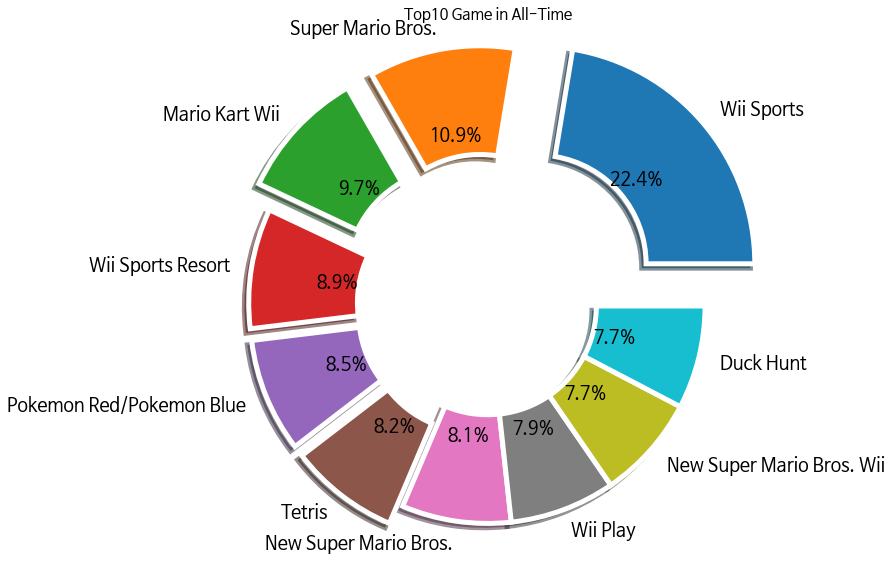

In [32]:
#All-Time 중에서 가장 많이 팔린 게임 Top10

def pieplot(x):
  data = x['total'].values.tolist()
  game_names = x['Name'].values.tolist()
  title = 'Top10 Game in All-Time'
  group_explodes = (0.3, 0.2, 0.2, 0.1, 0.1, 0.1, 0, 0, 0, 0)
  wedgeprops={'width': 0.5, 'edgecolor': 'w', 'linewidth': 5}

  plt.rcParams['figure.figsize'] = [15, 10]
  plt.pie(data,
        explode = group_explodes,
        shadow=True,
        startangle=0,
        autopct='%1.1f%%',
        textprops={'fontsize': 18},
        labels = game_names,
        wedgeprops=wedgeprops)
  plt.title(title, fontsize=15, pad=16)
        
  return plt.show()

pieplot(df_total)

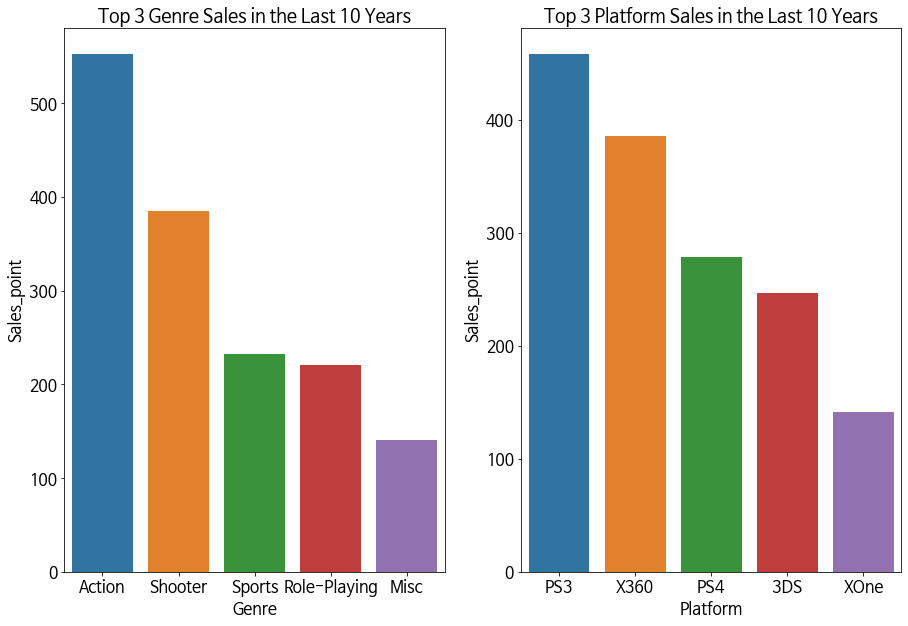

In [33]:
#최근 10년간 가장 인기있었던 장르와 플랫폼

def filter4(x):
  condition1 = (x.Year >= 2011) & (x.Year <= 2020)
  df_lated10 = x[condition1]
  df_lated10['total'] = df_lated10.loc[:, 'NA_Sales':'Other_Sales'].sum(axis=1)
  df_lated10 = df_lated10.sort_values(by='total', ascending=False).reset_index(drop=True)
  return df_lated10

def top5_genre_or_platform(x, col, col1):
    return x.groupby(col)[col1].sum().reset_index(name='sales').sort_values('sales', ascending=False).head(5)

df_lated10 = filter4(df)
genrefromtop5 = top5_genre_or_platform(df_lated10, 'Genre', 'total')
platfromtop5 = top5_genre_or_platform(df_lated10, 'Platform', 'total')

data_list = [genrefromtop5, platfromtop5]
columns_list = platform_sales.columns[1:]
labels = ['Genre','Platform']

fig, axs = plt.subplots(figsize=(15, 10), nrows=1, ncols=2)
for col, i, data in zip(columns_list, range(len(columns_list)), data_list):
    axs[i].set_title('Top 3 ' + labels[i] + ' Sales in the Last 10 Years', fontsize=18)
    sns.barplot(x=data.iloc[:,0], y=data.iloc[:,1], data=data, ax=axs[i])
    axs[i].tick_params(labelsize=16)
    axs[i].set_xlabel(labels[i], fontsize=16)
    axs[i].set_ylabel('Sales_point', fontsize=16)


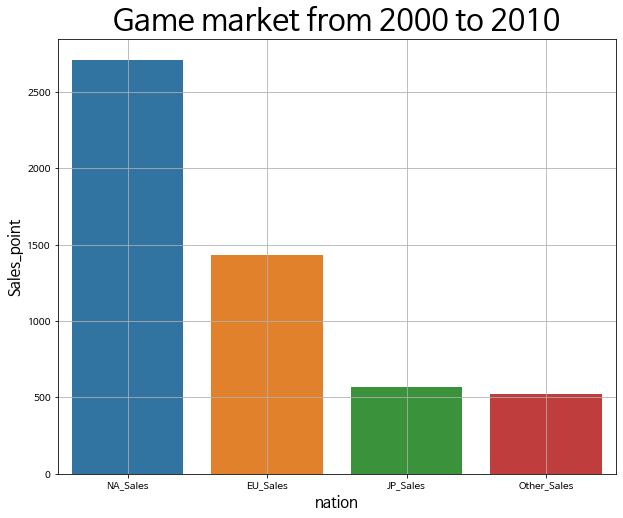

In [34]:
#Game market from 2000 to 2010
def filter99(x):
  condition2 = (x.Year >= 2000) & (x.Year <= 2010)
  game_market = x[condition2]
  game_market = game_market[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().reset_index()
  game_market.columns = ['nation', 'sales']
  return pd.DataFrame(game_market)

game_market = filter99(df)

def graph99(df):

  plt.figure(figsize=(10,8))
  sns.barplot(x='nation', y='sales', data=game_market)
  
  plt.xlabel('nation', fontsize=15)
  plt.ylabel('Sales_point', fontsize=15)
  plt.title('Game market from 2000 to 2010', fontsize=30)
  plt.grid(True)
  plt.show()
  return plt.show()

graph99(game_market)

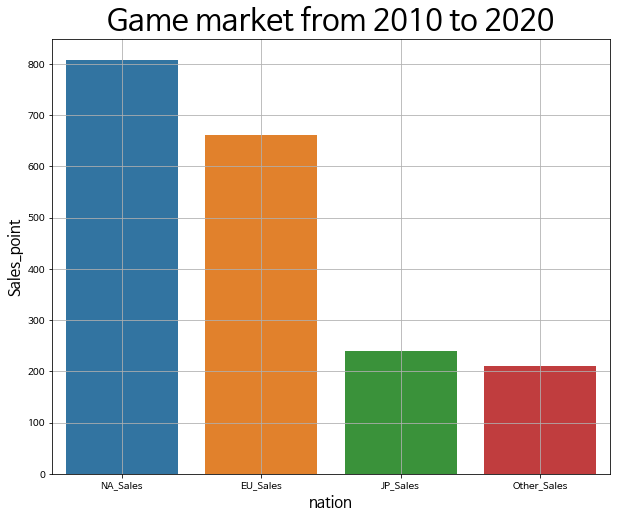

In [35]:
#Game market from 2010 to 2020
def filter7(x):
  condition3 = (x.Year >= 2011) & (x.Year <= 2020)
  game_market1 = x[condition3]
  game_market1 = game_market1[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().reset_index()
  game_market1.columns = ['nation', 'sales']
  return pd.DataFrame(game_market1)

game_market1 = filter7(df)

def graph98(df):

  plt.figure(figsize=(10,8))
  sns.barplot(x='nation', y='sales', data=game_market1)
  
  plt.xlabel('nation', fontsize=15)
  plt.ylabel('Sales_point', fontsize=15)
  plt.title('Game market from 2010 to 2020', fontsize=30)
  plt.grid(True)
  plt.show()
  return plt.show()

graph98(game_market1)

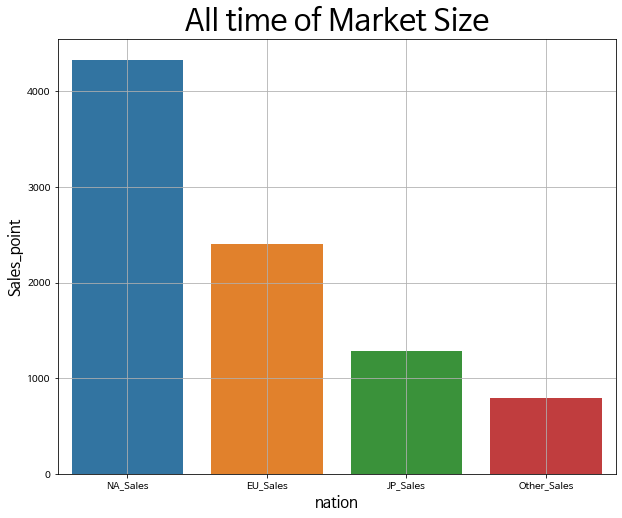

In [36]:
#All time of Market Size
def filtera(x):
  condition3 = (x.Year >= 1980) & (x.Year <= 2020)
  game_marketa = x[condition3]
  game_marketa = game_marketa[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum().reset_index()
  game_marketa.columns = ['nation', 'sales']
  return pd.DataFrame(game_marketa)

game_marketa = filtera(df)

def grapha(df):

  plt.figure(figsize=(10,8))
  sns.barplot(x='nation', y='sales', data=game_marketa)
  
  plt.xlabel('nation', fontsize=15)
  plt.ylabel('Sales_point', fontsize=15)
  plt.title('All time of Market Size', fontsize=30)
  plt.grid(True)
  plt.show()
  return plt.show()

grapha(game_marketa)

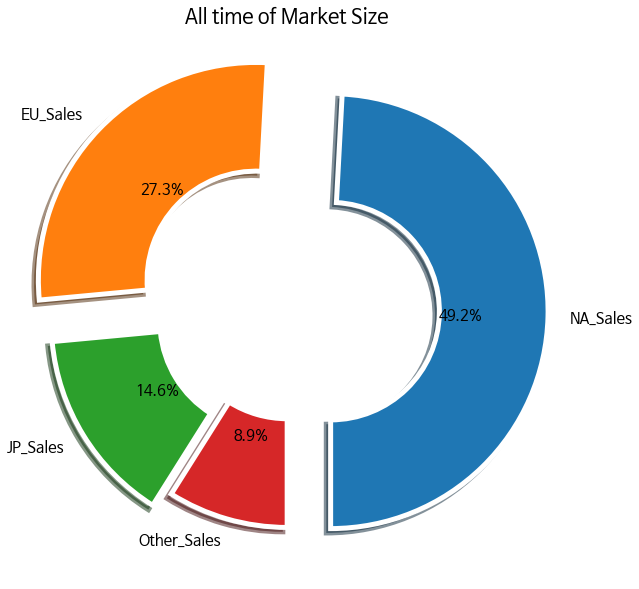

In [37]:
#All time of Market Size
def pieplot12(x):
  data = x['sales'].values.tolist()
  game_names = x['nation'].values.tolist()
  title = 'All time of Market Size'
  group_explodes = (0.2, 0.2, 0.1, 0)
  wedgeprops={'width': 0.5, 'edgecolor': 'w', 'linewidth': 5}

  plt.rcParams['figure.figsize'] = [15, 10]
  plt.pie(data,
        explode = group_explodes,
        shadow=True,
        startangle=270,
        autopct='%1.1f%%',
        textprops={'fontsize': 15},
        labels = game_names,
        wedgeprops=wedgeprops)
  plt.title(title, fontsize=20, pad=16)
        
  return plt.show()

pieplot12(game_marketa)

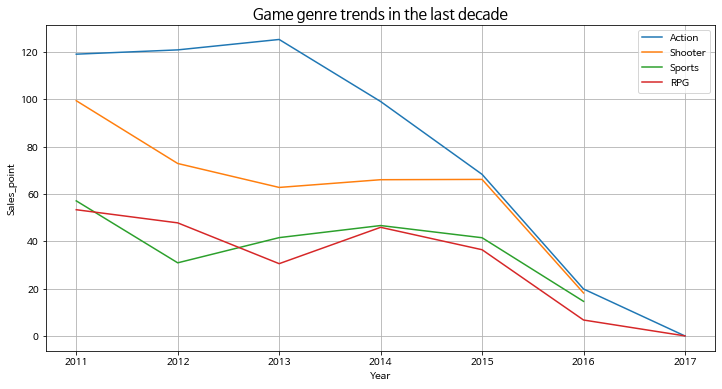

In [39]:
#최근 10년간 게임 장르 트렌드 Lineplot
final = df_lated10.loc[:,['Year', 'Genre', 'total']]
final1 = df_lated10.loc[:,['Year', 'Platform', 'total']]
final = final.dropna()
real = final.groupby(['Year', 'Genre'])['total'].sum().reset_index()
pd.DataFrame(real)

Action = real[real['Genre'] == 'Action'].drop('Genre', axis=1)
Shooter = real[real['Genre'] == 'Shooter'].drop('Genre', axis=1)
Sports = real[real['Genre'] == 'Sports'].drop('Genre', axis=1)
RPG = real[real['Genre'] == 'Role-Playing'].drop('Genre', axis=1)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
plt.plot(Action['Year'], Action['total'], label='Action')
plt.plot(Shooter['Year'], Shooter['total'], label='Shooter')
plt.plot(Sports['Year'], Sports['total'], label='Sports')
plt.plot(RPG['Year'], RPG['total'], label='RPG')

plt.grid(True)
plt.legend()
plt.xlabel('Year', fontsize=10)
plt.ylabel('Sales_point', fontsize=10)
plt.title('Game genre trends in the last decade', fontsize=15)
plt.show()

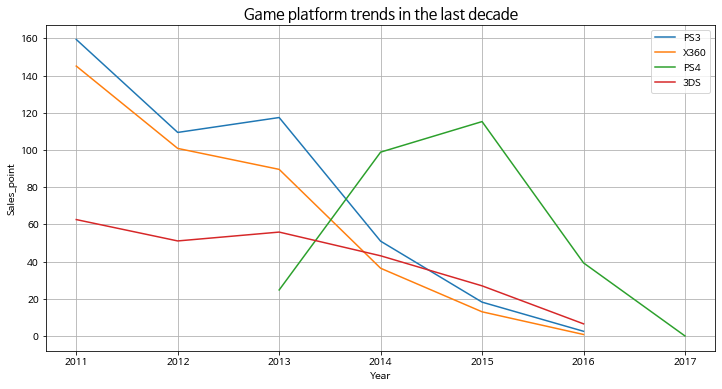

In [40]:
#최근 10년간 게임 플랫폼 트렌드 Lineplot

final1 = df_lated10.loc[:,['Year', 'Platform', 'total']]
real1 = final1.groupby(['Year','Platform'])['total'].sum().reset_index()
pd.DataFrame(real1)

real1
PS3 = real1[real1['Platform'] == 'PS3'].drop('Platform', axis=1)
X360 = real1[real1['Platform'] == 'X360'].drop('Platform', axis=1)
PS4 = real1[real1['Platform'] == 'PS4'].drop('Platform', axis=1)
TDS = real1[real1['Platform'] == '3DS'].drop('Platform', axis=1)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
plt.plot(PS3['Year'], PS3['total'], label='PS3')
plt.plot(X360['Year'], X360['total'], label='X360')
plt.plot(PS4['Year'], PS4['total'], label='PS4')
plt.plot(TDS['Year'], TDS['total'], label='3DS')

plt.grid(True)
plt.legend()
plt.xlabel('Year', fontsize=10)
plt.ylabel('Sales_point', fontsize=10)
plt.title('Game platform trends in the last decade', fontsize=15)
plt.show()

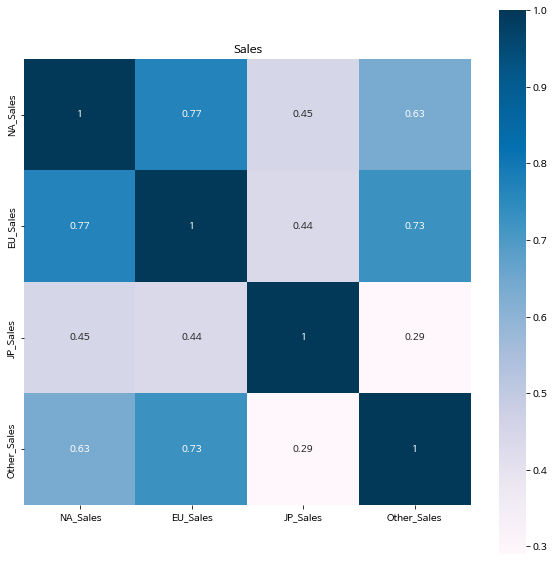

In [42]:
#Market간의 상관관계를 나타내는 HeatMap
comp_map = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 10))
plt.title("Sales")
sns.heatmap(comp_map.corr(), annot=True, linecolor = 'white', cmap=colormap, square=True)
plt.show()

# 가설검정
### Anova, ttest, chi test

In [43]:
!pip install scipy --upgrade

     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
#Anova

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

#H0 : 각 집단간의 평균차이는 없다.
#H1 : 각 집단간의 평균 차이가 있다.

NAsales = df['NA_Sales']
EUsales = df['EU_Sales']
JPsales = df['JP_Sales']
Othersales = df['Other_Sales']

print(NAsales.mean())
print(EUsales.mean())
print(JPsales.mean())

stats.f_oneway(NAsales, EUsales, JPsales, Othersales)

#P-Value < 0.05 이므로 귀무가설을 기각한다.
#따라서, 각 집단간의 평균차이는 있다고 볼 수 있다.


In [50]:
#Anova-Random seed
np.random.seed(42)

list = [NAsales, EUsales, JPsales]

for i in range(0, 3):
  globals()['rand_' + str(i)] = list[i].sample(frac=0.3) #표본 30%를 랜덤하게 뽑아서 진행하였다.

print(rand_0.mean())
print(rand_1.mean())
print(rand_2.mean())

stats.f_oneway(rand_0, rand_1, rand_2)

#P-Value < 0.05 이므로 귀무가설을 기각한다.
#따라서, 각 집단간의 평균차이는 있다고 볼 수 있다.

0.24883711588672033
0.15171922072705088
0.0805402691303469


F_onewayResult(statistic=113.85027711304475, pvalue=8.484147583978508e-50)

In [51]:
#two sample t-test
#H0 : NA_Sales의 평균과 EU_Sales의 평균은 차이가 없다.
#H1 : NA_Sales의 평균과 EU_Sales의 평균은 차이가 있다.
from scipy.stats import ttest_ind
NAsales_mean = df['NA_Sales'].mean()
EUsales_mean = df['EU_Sales'].mean()

stats.ttest_ind(df['NA_Sales'], df['EU_Sales'])

#P-Value < 0.05 이므로 귀무가설을 기각한다.
#따라서, 각 집단간의 평균차이는 있다고 볼 수 있다.

Ttest_indResult(statistic=15.831371100049903, pvalue=3.0384925458019944e-56)

In [47]:
#chi one sample test
#H0 : 게임 플랫폼 별 퍼블리셔 분포가 동일하다.
#H1 : 게임 플랫폼 별 퍼블리셔 분포가 동일하지 않다.

from scipy.stats import chisquare

df_chi_onesample = pd.crosstab(df['Platform'], df['Publisher'])
df_chi_onesample = df_chi_onesample.sum(axis=1)

chisquare(df_chi_onesample, axis=None)

#P-Value < 0.05 이므로 귀무가설을 기각한다.
#따라서, 게임 플랫폼 별 퍼블리셔 분포가 동일하지 않다고 볼 수 있다.


Power_divergenceResult(statistic=22194.368802902063, pvalue=0.0)

In [48]:
#chi two sample test
#H0 = 게임 플랫폼과 퍼블리셔는 서로 독립이다.
#H1 = 게임 플랫폼과 퍼블리셔는 서로 독립이 아니다.

from scipy.stats import chi2_contingency

chi2_contingency(df_chi_onesample)

#P-Value < 0.05 이므로 귀무가설을 기각한다.
#따라서, 게임 플랫폼과 퍼블리셔는 서로 독립이 아니라고 볼 수 있다.



(0.0,
 1.0,
 0,
 array([1.330e+02, 3.000e+00, 5.070e+02, 5.200e+01, 2.156e+03, 9.800e+01,
        7.960e+02, 5.560e+02, 2.700e+01, 1.000e+00, 3.190e+02, 9.800e+01,
        1.200e+01, 9.540e+02, 1.000e+00, 1.193e+03, 2.159e+03, 1.326e+03,
        3.360e+02, 1.211e+03, 4.110e+02, 1.730e+02, 6.000e+00, 2.390e+02,
        2.000e+00, 6.000e+00, 1.324e+03, 1.430e+02, 1.261e+03, 8.240e+02,
        2.130e+02]))